In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import json

%matplotlib inline

## Races info

In [2]:
df_races = pd.read_csv('./../data/clean/races_features.csv', index_col='race')
len(df_races)

159

# Results data

In [3]:
from utils.get_processed_data import get_results_df

df_results = get_results_df(df_races, anonimize=True)

Number of single results: 2000403
Number of individuals: 643055
Number of remaining single results: 945102
Number of remaining individuals: 399472
Number of races in results df: 156


In [4]:
# the SQL way
# --------------

# query = '''SELECT *
# FROM (
#          SELECT athlete, count(*) as count_races
#          FROM results
#          GROUP BY athlete
#      ) as t1
# ORDER BY count_races DESC'''

# cnx = mysql.connector.connect(user=cfg.mysql_user, database=cfg.mysql_db, password=cfg.mysql_pw, ssl_disabled=True)
# athletes_race_count = pd.read_sql(query, con=cnx)
# cnx.close()


from utils.get_processed_data import get_athletes_races_count

athletes_df = get_athletes_races_count(df_results)
athletes_df.head()

,athlete,n_different_races,n_races
0,u0,5,6
1,u1,16,25
2,u10,30,38
3,u100,5,6
4,u1000,1,1


In [5]:
# mininum of different races we want our athletes to have done
min_unique_race_count = 4

# What we are filtering with
max_count_races = 100 # probably similar names


valid_athletes = athletes_df.loc[
    (athletes_df['n_different_races']>=min_unique_race_count) 
    & (athletes_df['n_races']<=max_count_races)
]

athletes_df = athletes_df.loc[athletes_df['athlete'].isin(valid_athletes['athlete'])]

# use this df to filter original results data
df_results_filtered = df_results.loc[df_results['athlete'].isin(valid_athletes['athlete'])]
df_results_filtered = df_results_filtered.merge(valid_athletes, left_on="athlete", right_on="athlete", how="left")

print("Number of valid individuals:", len(valid_athletes))
print("Number of remaining single results:", len(df_results_filtered))
print("Number of races present in filtered results:", len(df_results_filtered.race.unique()))

Number of valid individuals: 45799
Number of remaining single results: 329329
Number of races present in filtered results: 156


### Some processing on the datasets

In [6]:
df_races = df_races.loc[df_results_filtered.race.unique()]
print("Number of remaining races:", len(df_races))

Number of remaining races: 156


## We need to make a `profile` for each athlete. What features could we extract from the data we have?

## Years in sport

In [7]:
years_in_sport = (df_results_filtered
     .groupby('athlete')
     .pipe(lambda g: ((g.date.max()-g.date.min()).astype('timedelta64[Y]'))+1) # add 1 so if only one race will be 1 year
     .rename('n_years_in_sport') 
)

athletes_df = athletes_df.merge(years_in_sport.astype(int), left_on="athlete", right_on="athlete", how="left")
athletes_df.head()

,athlete,n_different_races,n_races,n_years_in_sport
0,u0,5,6,4
1,u1,16,25,5
2,u10,30,38,5
3,u100,5,6,4
4,u10000,8,16,5


## Active years in sport

In [8]:
active_years = (
    df_results_filtered
        .groupby(['athlete', 'year'])
        .size()
        .reset_index()
        .groupby('athlete')
        .size()
        .rename("n_active_years_in_sport")
)

athletes_df = athletes_df.merge(active_years.astype(int), left_on="athlete", right_on="athlete", how="left")
athletes_df.head(20)

,athlete,n_different_races,n_races,n_years_in_sport,n_active_years_in_sport
0,u0,5,6,4,4
1,u1,16,25,5,5
2,u10,30,38,5,5
3,u100,5,6,4,5
4,u10000,8,16,5,5
5,u100010,4,6,2,2
6,u100013,8,10,4,5
7,u100019,8,17,5,5
8,u100020,5,5,3,4
9,u100021,6,7,4,4


## Avg number of race per active year

In [9]:
athletes_df['avg_n_races_year'] = athletes_df['n_races']/athletes_df['n_active_years_in_sport']
athletes_df.head()

,athlete,n_different_races,n_races,n_years_in_sport,n_active_years_in_sport,avg_n_races_year
0,u0,5,6,4,4,1.5
1,u1,16,25,5,5,5.0
2,u10,30,38,5,5,7.6
3,u100,5,6,4,5,1.2
4,u10000,8,16,5,5,3.2


## Unique races

In [10]:
unique_races = (
    df_results_filtered
        .groupby(['athlete', 'race'])
        .size()
        .reset_index()
        .groupby('athlete')
        .size()
        .rename("n_unique_races")
)

athletes_df = athletes_df.merge(unique_races.astype(int), left_on="athlete", right_on="athlete", how="left")
athletes_df.head()

,athlete,n_different_races,n_races,n_years_in_sport,n_active_years_in_sport,avg_n_races_year,n_unique_races
0,u0,5,6,4,4,1.5,5
1,u1,16,25,5,5,5.0,16
2,u10,30,38,5,5,7.6,30
3,u100,5,6,4,5,1.2,5
4,u10000,8,16,5,5,3.2,8


In [11]:
athletes_df['perc_unique_races'] = athletes_df['n_unique_races']/athletes_df['n_races']
athletes_df.head()

,athlete,n_different_races,n_races,n_years_in_sport,n_active_years_in_sport,avg_n_races_year,n_unique_races,perc_unique_races
0,u0,5,6,4,4,1.5,5,0.833333
1,u1,16,25,5,5,5.0,16,0.640000
2,u10,30,38,5,5,7.6,30,0.789474
3,u100,5,6,4,5,1.2,5,0.833333
4,u10000,8,16,5,5,3.2,8,0.500000


# Internationality of the racer?

## Are the races raced in the same region/country?

In [12]:
len(df_races), len(df_results.race.unique())

(156, 156)

In [13]:
# hash for races (region/country)
region_hash = {
    race: region for race,region in df_races.reset_index()[['race', 'region']].values
}
country_hash = {
    race: region for race,region in df_races.reset_index()[['race', 'country_code']].values
}


internationality = (
    df_results_filtered
        .groupby(['athlete', 'race'])
        .size()
        .reset_index()
)

internationality['region'] = internationality.loc[:, 'race'].apply(lambda x: region_hash[x])
internationality['country'] = internationality.loc[:, 'race'].apply(lambda x: country_hash[x])

internationality_region = (
    internationality
        .groupby(['athlete', 'region'])
        .size()
        .reset_index()
        .groupby('athlete')
        .size()
        .rename("n_regions_raced")
)

internationality_country = (
    internationality
        .groupby(['athlete', 'country'])
        .size()
        .reset_index()
        .groupby('athlete')
        .size()
        .rename("n_countries_raced")
)



athletes_df = athletes_df.merge(internationality_region.astype(int), left_on="athlete", right_on="athlete", how="left")
athletes_df = athletes_df.merge(internationality_country.astype(int), left_on="athlete", right_on="athlete", how="left")
athletes_df.head()

,athlete,n_different_races,n_races,n_years_in_sport,n_active_years_in_sport,avg_n_races_year,n_unique_races,perc_unique_races,n_regions_raced,n_countries_raced
0,u0,5,6,4,4,1.5,5,0.833333,4,4
1,u1,16,25,5,5,5.0,16,0.640000,6,11
2,u10,30,38,5,5,7.6,30,0.789474,6,10
3,u100,5,6,4,5,1.2,5,0.833333,2,4
4,u10000,8,16,5,5,3.2,8,0.500000,2,4


In [14]:
# What's the percentage of races done in different regions?
athletes_df["perc_races_in_diff_regions"] = athletes_df["n_regions_raced"]/athletes_df["n_unique_races"]
# What's the percentage of races done in different countries?
athletes_df["perc_races_in_diff_countries"] = athletes_df["n_countries_raced"]/athletes_df["n_unique_races"]

athletes_df.head()

,athlete,n_different_races,n_races,n_years_in_sport,n_active_years_in_sport,avg_n_races_year,n_unique_races,perc_unique_races,n_regions_raced,n_countries_raced,perc_races_in_diff_regions,perc_races_in_diff_countries
0,u0,5,6,4,4,1.5,5,0.833333,4,4,0.800,0.800000
1,u1,16,25,5,5,5.0,16,0.640000,6,11,0.375,0.687500
2,u10,30,38,5,5,7.6,30,0.789474,6,10,0.200,0.333333
3,u100,5,6,4,5,1.2,5,0.833333,2,4,0.400,0.800000
4,u10000,8,16,5,5,3.2,8,0.500000,2,4,0.250,0.500000


## Percentage of race done in the home country?

In [15]:
df_results_filtered['race_country'] = df_results_filtered.loc[:, 'race'].apply(lambda x: country_hash[x])
df_results_filtered['same_country'] = df_results_filtered['country'] == df_results_filtered['race_country']
df_results_filtered[['country', 'race_country', 'same_country']].head()

,country,race_country,same_country
0,USA,CHN,False
1,AUS,CHN,False
2,JPN,CHN,False
3,AUS,CHN,False
4,JPN,CHN,False


In [16]:
home_races = (
    df_results_filtered
        .groupby(['athlete', 'race'])['same_country']
        .sum()
        .reset_index()
        .groupby('athlete')
        .sum()
        .reset_index()
        .rename(columns={'same_country': 'n_races_in_home_country'})
)

athletes_df = athletes_df.merge(home_races, left_on="athlete", right_on="athlete", how="left")
athletes_df.head()

,athlete,n_different_races,n_races,n_years_in_sport,n_active_years_in_sport,avg_n_races_year,n_unique_races,perc_unique_races,n_regions_raced,n_countries_raced,perc_races_in_diff_regions,perc_races_in_diff_countries,n_races_in_home_country
0,u0,5,6,4,4,1.5,5,0.833333,4,4,0.800,0.800000,0.0
1,u1,16,25,5,5,5.0,16,0.640000,6,11,0.375,0.687500,9.0
2,u10,30,38,5,5,7.6,30,0.789474,6,10,0.200,0.333333,19.0
3,u100,5,6,4,5,1.2,5,0.833333,2,4,0.400,0.800000,3.0
4,u10000,8,16,5,5,3.2,8,0.500000,2,4,0.250,0.500000,3.0


## Gender

In [17]:
df_results_filtered['gender'] = None
df_results_filtered.loc[df_results_filtered['division'].str.contains("M"), 'gender'] = "M"
df_results_filtered.loc[df_results_filtered['division'].str.contains("F"), 'gender'] = "F"
df_results_filtered.head()

,id,athlete,division,rankdiv,rankgender,rankoverall,swim,t1,bike,t2,...,fulldata,score,swim_score,run_score,bike_score,gender,n_different_races,n_races,race_country,same_country
0,1518207,u0,M75-79,1,1073,1209,2440,678,11150,469,...,0,98.4,100.0,86.1,100.0,M,5,6,CHN,False
1,1518208,u1,MPRO,1,1,1,1569,209,7416,142,...,0,99.7,100.0,97.7,100.0,M,16,25,CHN,False
2,1518209,u2,M75-79,2,1141,1301,3539,679,13127,461,...,0,97.1,77.2,100.0,90.7,M,5,7,CHN,False
3,1518210,u3,M65-69,1,181,202,1895,377,9944,243,...,0,99.9,100.0,100.0,99.7,M,6,11,CHN,False
4,1518211,u4,M80-84,1,1281,1475,3135,784,13528,726,...,0,100.0,100.0,100.0,100.0,M,4,4,CHN,False


In [18]:
gender = (df_results_filtered
     .groupby(['athlete', 'gender'])
     .size()
     .reset_index()
     .rename(columns={0: 'n'})
     .pivot(index='athlete', columns='gender', values='n')
     .idxmax(axis=1)
     .rename('gender')
)

athletes_df = athletes_df.merge(gender, left_on="athlete", right_on="athlete", how="left")
athletes_df.head()

,athlete,n_different_races,n_races,n_years_in_sport,n_active_years_in_sport,avg_n_races_year,n_unique_races,perc_unique_races,n_regions_raced,n_countries_raced,perc_races_in_diff_regions,perc_races_in_diff_countries,n_races_in_home_country,gender
0,u0,5,6,4,4,1.5,5,0.833333,4,4,0.800,0.800000,0.0,M
1,u1,16,25,5,5,5.0,16,0.640000,6,11,0.375,0.687500,9.0,M
2,u10,30,38,5,5,7.6,30,0.789474,6,10,0.200,0.333333,19.0,M
3,u100,5,6,4,5,1.2,5,0.833333,2,4,0.400,0.800000,3.0,M
4,u10000,8,16,5,5,3.2,8,0.500000,2,4,0.250,0.500000,3.0,M


## Age Groups
This one is tricky, there could be several age groups is athlete long enough in the sport ... will have to average

In [19]:
df_results_filtered['ag'] = df_results_filtered.division.apply(
    lambda x: list(map(int, re.match("[M|F](\d+)-(\d+)", x).groups()))
    if re.match("[M|F](\d+)-(\d+)", x) 
    else [np.nan, np.nan]
)
df_results_filtered['ag_min'] = df_results_filtered.ag.apply(lambda x: x[0])
df_results_filtered['ag_max'] = df_results_filtered.ag.apply(lambda x: x[1])
df_results_filtered.head()

,id,athlete,division,rankdiv,rankgender,rankoverall,swim,t1,bike,t2,...,run_score,bike_score,gender,n_different_races,n_races,race_country,same_country,ag,ag_min,ag_max
0,1518207,u0,M75-79,1,1073,1209,2440,678,11150,469,...,86.1,100.0,M,5,6,CHN,False,"[75, 79]",75.0,79.0
1,1518208,u1,MPRO,1,1,1,1569,209,7416,142,...,97.7,100.0,M,16,25,CHN,False,"[nan, nan]",NaN,NaN
2,1518209,u2,M75-79,2,1141,1301,3539,679,13127,461,...,100.0,90.7,M,5,7,CHN,False,"[75, 79]",75.0,79.0
3,1518210,u3,M65-69,1,181,202,1895,377,9944,243,...,100.0,99.7,M,6,11,CHN,False,"[65, 69]",65.0,69.0
4,1518211,u4,M80-84,1,1281,1475,3135,784,13528,726,...,100.0,100.0,M,4,4,CHN,False,"[80, 84]",80.0,84.0


In [20]:
age_groups = (
    df_results_filtered
        .groupby(["athlete", "division"])
        .size()
        .reset_index()
        .groupby(['athlete'])
        .size()
        .reset_index()
        .rename(columns={0: "n_ag"})
)
age_groups.sort_values("n_ag", ascending=False).head()

,athlete,n_ag
4744,u11933,11
23954,u28031,11
35057,u5682,11
15590,u19168,10
27085,u32591,10


In [21]:
df_results_filtered.loc[df_results_filtered.athlete=="u100", ["ag_min", "ag_max"]].mean()

ag_min    27.5
ag_max    31.5
dtype: float64

In [22]:
age = (df_results_filtered
     .groupby(['athlete'])
     .mean()[['ag_min', 'ag_max']]
     .mean(axis=1)
     .reset_index()
     .rename(columns = {0: "age"})
)

athletes_df = athletes_df.merge(age, left_on="athlete", right_on="athlete", how="left")
athletes_df.head()

,athlete,n_different_races,n_races,n_years_in_sport,n_active_years_in_sport,avg_n_races_year,n_unique_races,perc_unique_races,n_regions_raced,n_countries_raced,perc_races_in_diff_regions,perc_races_in_diff_countries,n_races_in_home_country,gender,age
0,u0,5,6,4,4,1.5,5,0.833333,4,4,0.800,0.800000,0.0,M,78.666667
1,u1,16,25,5,5,5.0,16,0.640000,6,11,0.375,0.687500,9.0,M,NaN
2,u10,30,38,5,5,7.6,30,0.789474,6,10,0.200,0.333333,19.0,M,NaN
3,u100,5,6,4,5,1.2,5,0.833333,2,4,0.400,0.800000,3.0,M,29.500000
4,u10000,8,16,5,5,3.2,8,0.500000,2,4,0.250,0.500000,3.0,M,42.000000


## Rank

In [23]:
df_results_filtered.head()

,id,athlete,division,rankdiv,rankgender,rankoverall,swim,t1,bike,t2,...,run_score,bike_score,gender,n_different_races,n_races,race_country,same_country,ag,ag_min,ag_max
0,1518207,u0,M75-79,1,1073,1209,2440,678,11150,469,...,86.1,100.0,M,5,6,CHN,False,"[75, 79]",75.0,79.0
1,1518208,u1,MPRO,1,1,1,1569,209,7416,142,...,97.7,100.0,M,16,25,CHN,False,"[nan, nan]",NaN,NaN
2,1518209,u2,M75-79,2,1141,1301,3539,679,13127,461,...,100.0,90.7,M,5,7,CHN,False,"[75, 79]",75.0,79.0
3,1518210,u3,M65-69,1,181,202,1895,377,9944,243,...,100.0,99.7,M,6,11,CHN,False,"[65, 69]",65.0,69.0
4,1518211,u4,M80-84,1,1281,1475,3135,784,13528,726,...,100.0,100.0,M,4,4,CHN,False,"[80, 84]",80.0,84.0


In [24]:
rank = (df_results_filtered
     .groupby(['race', 'year'])
     .apply(lambda g: g['rankoverall']/g.rankoverall.max())
     .reset_index()
).merge(df_results_filtered
     .groupby(['race', 'year'])
     .apply(lambda g: g['athlete'])
     .reset_index()
)
rank.head()

,race,year,level_2,rankoverall,athlete
0,Arizona70.3,2015,75800,0.061299,u120595
1,Arizona70.3,2015,75807,0.440988,u13975
2,Arizona70.3,2015,75808,0.007319,u68687
3,Arizona70.3,2015,75809,0.119854,u132011
4,Arizona70.3,2015,75810,0.019213,u14444


In [25]:
selection = ["athlete", "swim_score", "bike_score", "run_score"]

activity_scores = (
    # keep only those who finished the race
    df_results_filtered.loc[(df_results_filtered.loc[:, selection][selection[1:]]>0).sum(axis=1) == 3, selection]
        .groupby('athlete')
        .mean()
        .reset_index()
)

athletes_df = athletes_df.merge(activity_scores, left_on="athlete", right_on="athlete", how="left")
athletes_df.head()

,athlete,n_different_races,n_races,n_years_in_sport,n_active_years_in_sport,avg_n_races_year,n_unique_races,perc_unique_races,n_regions_raced,n_countries_raced,perc_races_in_diff_regions,perc_races_in_diff_countries,n_races_in_home_country,gender,age,swim_score,bike_score,run_score
0,u0,5,6,4,4,1.5,5,0.833333,4,4,0.800,0.800000,0.0,M,78.666667,100.000000,100.000000,94.450000
1,u1,16,25,5,5,5.0,16,0.640000,6,11,0.375,0.687500,9.0,M,NaN,99.990000,99.500000,96.245000
2,u10,30,38,5,5,7.6,30,0.789474,6,10,0.200,0.333333,19.0,M,NaN,97.578571,97.342857,95.971429
3,u100,5,6,4,5,1.2,5,0.833333,2,4,0.400,0.800000,3.0,M,29.500000,89.166667,92.800000,91.233333
4,u10000,8,16,5,5,3.2,8,0.500000,2,4,0.250,0.500000,3.0,M,42.000000,94.000000,97.060000,98.070000


In [26]:
athletes_df.head()

,athlete,n_different_races,n_races,n_years_in_sport,n_active_years_in_sport,avg_n_races_year,n_unique_races,perc_unique_races,n_regions_raced,n_countries_raced,perc_races_in_diff_regions,perc_races_in_diff_countries,n_races_in_home_country,gender,age,swim_score,bike_score,run_score
0,u0,5,6,4,4,1.5,5,0.833333,4,4,0.800,0.800000,0.0,M,78.666667,100.000000,100.000000,94.450000
1,u1,16,25,5,5,5.0,16,0.640000,6,11,0.375,0.687500,9.0,M,NaN,99.990000,99.500000,96.245000
2,u10,30,38,5,5,7.6,30,0.789474,6,10,0.200,0.333333,19.0,M,NaN,97.578571,97.342857,95.971429
3,u100,5,6,4,5,1.2,5,0.833333,2,4,0.400,0.800000,3.0,M,29.500000,89.166667,92.800000,91.233333
4,u10000,8,16,5,5,3.2,8,0.500000,2,4,0.250,0.500000,3.0,M,42.000000,94.000000,97.060000,98.070000


In [27]:
len(athletes_df)

45799

# UMAP

In [28]:
results_races_count = (
    df_results_filtered
        .groupby(['athlete', 'race'])
        .size()
        .reset_index()
        .rename(columns={0: 'count'})
)

# Add demographics info for users (if we want to filter later)
gender = (df_results_filtered
     .groupby(['athlete', 'gender'])
     .size()
     .reset_index()
     .rename(columns={0: 'n'})
     .pivot(index='athlete', columns='gender', values='n')
     .idxmax(axis=1)
     .rename('gender')
)

country = (df_results_filtered
     .groupby(['athlete', 'country'])
     .size()
     .reset_index()
     .rename(columns={0: 'n'})
     .pivot(index='athlete', columns='country', values='n')
     .idxmax(axis=1)
     .rename('country')
)

results_races_count = results_races_count.merge(gender, left_on = 'athlete', right_on = 'athlete', how = 'left')
results_races_count = results_races_count.merge(country, left_on = 'athlete', right_on = 'athlete', how = 'left')

results_races_count.head()

,athlete,race,count,gender,country
0,u0,cozumel,1,M,USA
1,u0,liuzhou70.3,1,M,USA
2,u0,mardelplata,1,M,USA
3,u0,newzealand,1,M,USA
4,u0,xiamen70.3,2,M,USA


In [29]:
data = results_races_count.pivot(index='race', columns='athlete', values='count').fillna(0)
data.head()

athlete,u0,u1,u10,u100,u10000,u100010,u100013,u100019,u100020,u100021,...,u9994,u99941,u99949,u99955,u9996,u9997,u99972,u99987,u99991,u99998
race,,,,,,,,,,,,,,,,,,,,,
Arizona70.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CostaNavarino70.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DunLaoghaire70.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Florianopolis70.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Haugesund70.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
data_in = data.values

In [31]:
from sklearn.decomposition import PCA

# run PCA
pca = PCA(n_components=10)
pca.fit(data_in)
out = pca.transform(data_in)

In [32]:
color_region_hash = {region: i for i,region in enumerate(df_races['region'].unique())}
color_country_hash = {country: i for i,country in enumerate(df_races['country_code'].unique())}

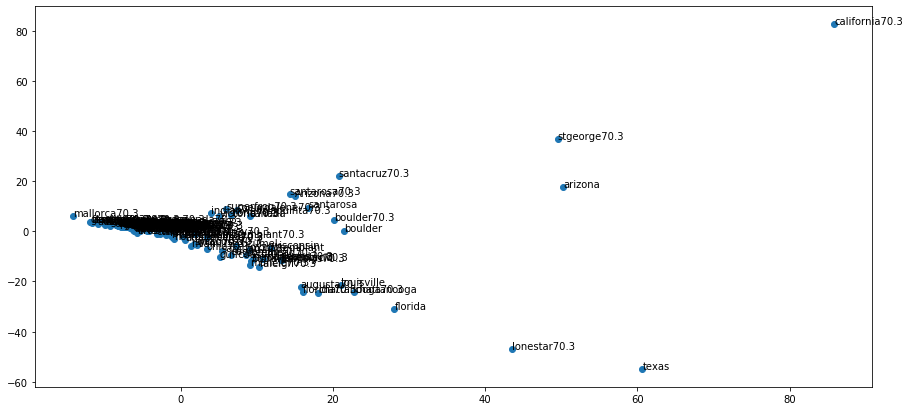

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(figsize=(15, 7))

ax.scatter(out[:, 0], out[:, 1])

for i, race in enumerate(data.index):
    ax.annotate(race, (out[i, 0], out[i, 1]))

# Global Model

/miniconda3/envs/data-science/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components


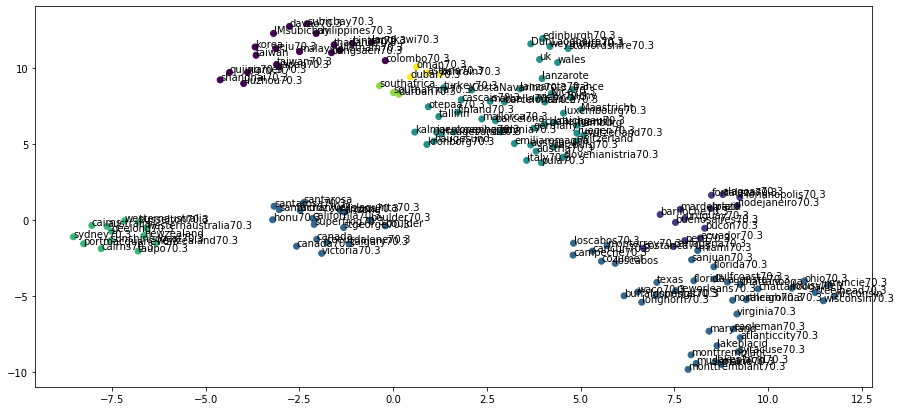

In [34]:
import umap

# run UMAP
umap_model = umap.UMAP(n_neighbors=5,
                       min_dist=0.9,
                       metric='cosine')
umap_embedding = umap_model.fit_transform(data_in)


fig,ax = plt.subplots(figsize=(15, 7))

ax.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=[color_region_hash[df_races.loc[race, 'region']] for race in data.index])
    
for i, race in enumerate(data.index):
    ax.annotate(race, (umap_embedding[i, 0], umap_embedding[i, 1]))

### UMAP after matrix factorization

In [35]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
svd.fit(data_in)
data_svd = svd.transform(data_in)

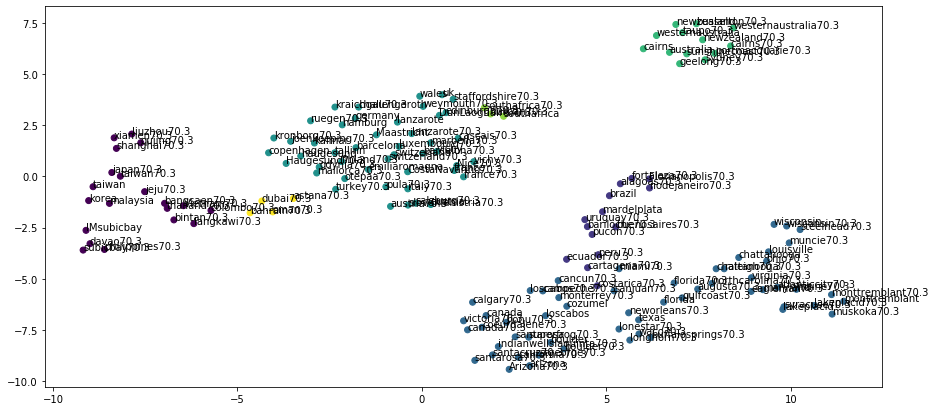

In [36]:
# run UMAP
umap_model = umap.UMAP(n_neighbors=5,
                       min_dist=0.9,
                       metric='cosine')
umap_embedding = umap_model.fit_transform(data_svd)


fig,ax = plt.subplots(figsize=(15, 7))

ax.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=[color_region_hash[df_races.loc[race, 'region']] for race in data.index])
    
for i, race in enumerate(data.index):
    ax.annotate(race, (umap_embedding[i, 0], umap_embedding[i, 1]))

## Selection of groups

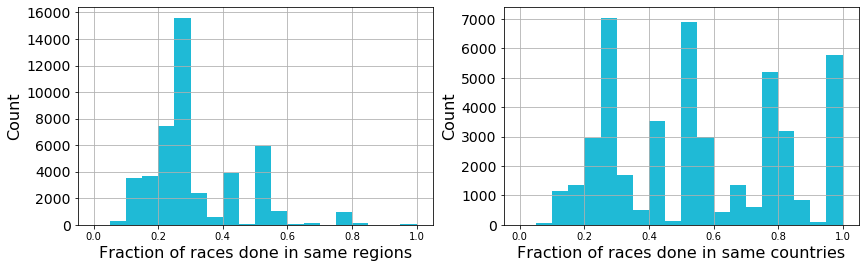

In [37]:
fig,axes = plt.subplots(ncols = 2, figsize=(14, 4))

athletes_df['perc_races_in_diff_regions'].hist(bins=np.arange(0., 1.05, 0.05), ax=axes[0], color='#1FBAD6')
athletes_df['perc_races_in_diff_countries'].hist(bins=np.arange(0., 1.05, 0.05), ax=axes[1], color='#1FBAD6')

for i,label in enumerate(['regions', 'countries']):
    for tick in axes[i].yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    axes[i].set_xlabel(f'Fraction of races done in same {label}', size=16)
    axes[i].set_ylabel('Count', size=16)

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)


# fig.savefig('figs/athlete-perc-races-in-diff-countries.pdf')

In [50]:
group1 = athletes_df.loc[athletes_df['perc_races_in_diff_countries'] <= 0.75, 'athlete'].values
group2 = athletes_df.loc[athletes_df['perc_races_in_diff_countries'] > 0.75, 'athlete'].values

idx_group1 = np.where(data.columns.isin(group1))[0]
idx_group2 = np.where(data.columns.isin(group2))[0]

len(group1), len(group2)

(35718, 10081)

/miniconda3/envs/data-science/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


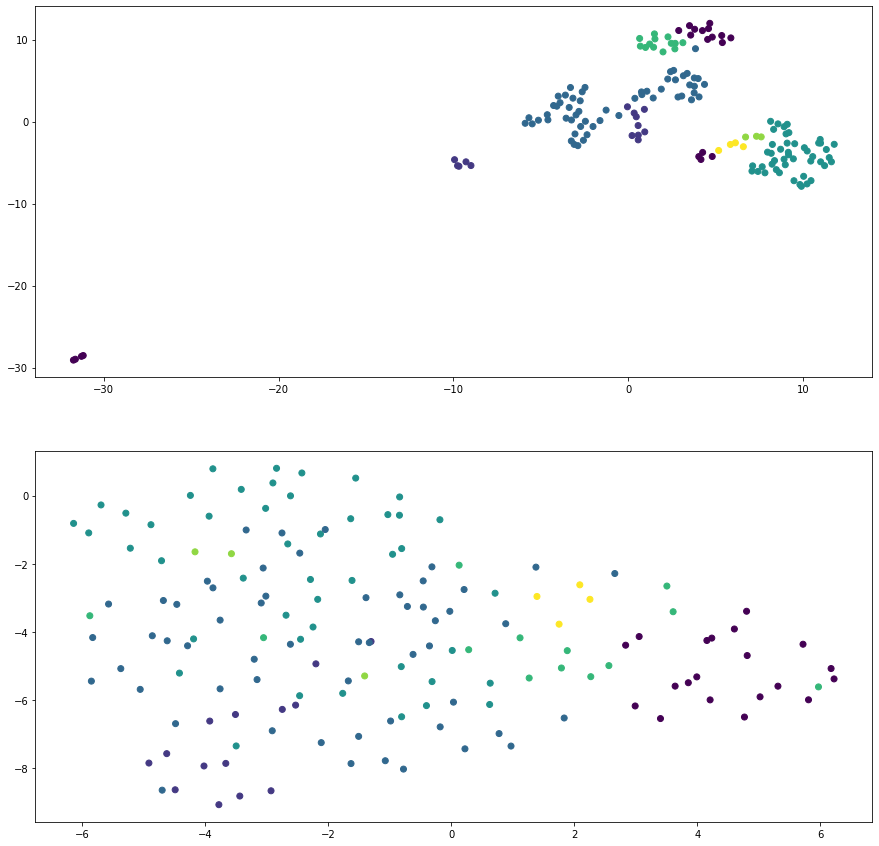

In [51]:
data_group1 = (
    results_races_count
        .loc[results_races_count.athlete.isin(group1)]
        .pivot(index='race', columns='athlete', values='count')
        .fillna(0)
)

data_group2 = (
    results_races_count
        .loc[results_races_count.athlete.isin(group2)]
        .pivot(index='race', columns='athlete', values='count')
        .fillna(0)
)

fig,axes = plt.subplots(nrows=2, figsize=(15, 15))

for i,d in enumerate([data_group1, data_group2]):
    svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
    svd.fit(d.values)
    data_svd = svd.transform(d.values)
    
    # run UMAP
    umap_model = umap.UMAP(n_neighbors=5,
                           min_dist=0.9,
                           metric='cosine')
    umap_embedding = umap_model.fit_transform(data_svd)

    axes[i].scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=[color_region_hash[df_races.loc[race, 'region']] for race in data.index])

#     for j, race in enumerate(data.index):
#         axes[i].annotate(race, (umap_embedding[j, 0], umap_embedding[j, 1]))

# Separate groups models

In [52]:
import scipy.sparse as sparse

from implicit_local.evaluation import train_test_split, mean_average_precision_at_k, ndcg_at_k
from implicit.als import AlternatingLeastSquares


# GROUPS models

sparse_item_user_group1 = sparse.csr_matrix(data_group1.values)
sparse_item_user_group2 = sparse.csr_matrix(data_group2.values)

sparse_item_user_group1 = sparse.csr_matrix(data_group1.values)
sparse_item_user_group2 = sparse.csr_matrix(data_group2.values)

print("Matrix size:", sparse_item_user_group1.shape, sparse_item_user_group2.shape)  
    
train_group1, test_group1 = train_test_split(sparse_item_user_group1, train_percentage=0.8)
train_group2, test_group2 = train_test_split(sparse_item_user_group2, train_percentage=0.8)

train_conf_group1 = (train_group1 * 5.5).astype('double')
train_conf_group2 = (train_group2 * 5.5).astype('double')

model_group1 = AlternatingLeastSquares(factors=18, regularization=0.01, iterations=50)
model_group1.fit(train_conf_group1)

model_group2 = AlternatingLeastSquares(factors=18, regularization=0.01, iterations=50)
model_group2.fit(train_conf_group2)

  1%|          | 0.5/50 [00:00<00:10,  4.79it/s]

Matrix size: (156, 35718) (156, 10081)


100%|██████████| 50.0/50 [00:05<00:00,  8.97it/s]
100%|██████████| 50.0/50 [00:01<00:00, 31.26it/s]


In [53]:
ndcg_at_k(model_group1, train_group1.T.tocsr(), test_group1.T.tocsr(), K=10, num_threads=4, show_progress=False)

0.3925623331395103

In [54]:
ndcg_at_k(model_group2, train_group2.T.tocsr(), test_group2.T.tocsr(), K=10, num_threads=4, show_progress=False)

0.27953168323559924

In [55]:
from utils.evaluation_utils import make_train, binarize


In [56]:
users_vec_group1 = model_group1.user_factors
items_vec_group1 = model_group1.item_factors

users_vec_group2 = model_group2.user_factors
items_vec_group2 = model_group2.item_factors

# make prediction matrix
all_predictions_group1 = items_vec_group1.dot(users_vec_group1.T)
all_predictions_group2 = items_vec_group2.dot(users_vec_group2.T)

all_predictions_group1.shape, all_predictions_group2.shape

((156, 35718), (156, 10081))

In [57]:
# get the relevant users to use in movel validation
users_true_labels_group1 = sparse.csc_matrix(np.sign(test_group1.toarray()))
users_predictions_group1 = all_predictions_group1#[:, users_modified_idx]
users_true_labels_group2 = sparse.csc_matrix(np.sign(test_group2.toarray()))
users_predictions_group2 = all_predictions_group2#[:, users_modified_idx]

# binarize using the half range for each users
cut_at = 0.5
users_predictions_binarized_group1 = (users_predictions_group1>(users_predictions_group1.max(axis=0)-users_predictions_group1.min(axis=0))*cut_at).astype(int)
users_predictions_binarized_group2 = (users_predictions_group2>(users_predictions_group2.max(axis=0)-users_predictions_group2.min(axis=0))*cut_at).astype(int)

# scale predictions in the [0, 1] interval
users_predictions_scaled_group1 = (users_predictions_group1 - users_predictions_group1.min(axis=0))/(users_predictions_group1.max(axis=0)-users_predictions_group1.min(axis=0))
users_predictions_scaled_group1[np.isnan(users_predictions_scaled_group1)] = 0
users_predictions_scaled_group2 = (users_predictions_group2 - users_predictions_group2.min(axis=0))/(users_predictions_group2.max(axis=0)-users_predictions_group2.min(axis=0))
users_predictions_scaled_group2[np.isnan(users_predictions_scaled_group2)] = 0

/miniconda3/envs/data-science/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/miniconda3/envs/data-science/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


In [58]:
from sklearn.metrics import recall_score, precision_score, average_precision_score, f1_score, roc_curve, roc_auc_score

# flatten arrays Group1
y_true_group1 = users_true_labels_group1.toarray().ravel()
y_pred_group1 = users_predictions_binarized_group1.ravel()
y_pred_scaled_group1 = users_predictions_scaled_group1.ravel()

# flatten arrays Group2
y_true_group2 = users_true_labels_group2.toarray().ravel()
y_pred_group2 = users_predictions_binarized_group2.ravel()
y_pred_scaled_group2 = users_predictions_scaled_group2.ravel()


# recall, precision, and f1 are definied for binarized (non-continuous) values 
# of predictions
print('Group 1')
print(f'Recall: {recall_score(y_true_group1, y_pred_group1):.3f}')
print(f'Precision: {precision_score(y_true_group1, y_pred_group1):.3f}')
print(f'Average Precision: {average_precision_score(y_true_group1, y_pred_group1):.3f}')
print(f'F1 score: {f1_score(y_true_group1, y_pred_group1):.3f}')

# roc-auc is more accurate when using continuous predictions.
auc_score_group1 = roc_auc_score(y_true_group1, y_pred_scaled_group1)
print(f'ROC-AUC: {auc_score_group1:.3f}')

# recall, precision, and f1 are definied for binarized (non-continuous) values 
# of predictions
print('Group 2')
print(f'Recall: {recall_score(y_true_group2, y_pred_group2):.3f}')
print(f'Precision: {precision_score(y_true_group2, y_pred_group2):.3f}')
print(f'Average Precision: {average_precision_score(y_true_group2, y_pred_group2):.3f}')
print(f'F1 score: {f1_score(y_true_group2, y_pred_group2):.3f}')

# roc-auc is more accurate when using continuous predictions.
auc_score_group2 = roc_auc_score(y_true_group2, y_pred_scaled_group2)
print(f'ROC-AUC: {auc_score_group2:.3f}')

Group 1
Recall: 0.327
Precision: 0.056
Average Precision: 0.023
F1 score: 0.096
ROC-AUC: 0.809
Group 2
Recall: 0.154
Precision: 0.035
Average Precision: 0.011
F1 score: 0.057
ROC-AUC: 0.737


/miniconda3/envs/data-science/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/miniconda3/envs/data-science/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


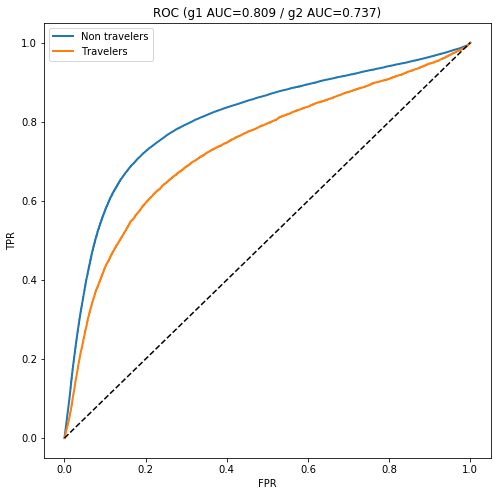

In [59]:
# plot ROC curve
fpr_group1, tpr_group1, thresholds = roc_curve(y_true_group1, y_pred_scaled_group1)
fpr_group2, tpr_group2, thresholds = roc_curve(y_true_group2, y_pred_scaled_group2)

fig,ax = plt.subplots(figsize=(8, 8))
ax.plot(fpr_group1, tpr_group1, lw=2, label='Non travelers')
ax.plot(fpr_group2, tpr_group2, lw=2, label='Travelers')
ax.plot([0, 1], [0, 1], 'k--')
ax.set_title(f'ROC (g1 AUC={auc_score_group1:.3f} / g2 AUC={auc_score_group2:.3f})')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR');
ax.legend()

# Global model

In [60]:
import implicit
import pickle
import json

# GLOBAL MODEL
filename_base = './../flask_app/nostrappdamus/model/data'

# load the model from disk
model = pickle.load(open(f"{filename_base}/als_model.sav", 'rb'))
  
# load
item_user_sparse = sparse.load_npz(f"{filename_base}/als_sparse_matrix.npz")
with open(f"{filename_base}/als_hash.json", "r") as f:
    hash_code_to_race = json.loads(f.read()) 

In [71]:
users_vec = model.user_factors
items_vec = model.item_factors

# make prediction matrix
all_predictions = items_vec.dot(users_vec.T)

all_predictions.shape

(156, 45799)

In [97]:
train, test, users_modified_idx = make_train(item_user_sparse, perc_test = 0.8)
print(f'{len(users_modified_idx)} have results that have been altered')

45757 have results that have been altered


In [98]:
# get the relevant users to use in movel validation
users_true_labels_group1 = test[:, idx_group1]
users_predictions_group1 = all_predictions[:, idx_group1]#[:, users_modified_idx]
users_true_labels_group2 = test[:, idx_group2]
users_predictions_group2 = all_predictions[:, idx_group2]#[:, users_modified_idx]

# binarize using the half range for each users
cut_at = 0.5
users_predictions_binarized_group1 = (users_predictions_group1>(users_predictions_group1.max(axis=0)-users_predictions_group1.min(axis=0))*cut_at).astype(int)
users_predictions_binarized_group2 = (users_predictions_group2>(users_predictions_group2.max(axis=0)-users_predictions_group2.min(axis=0))*cut_at).astype(int)

# scale predictions in the [0, 1] interval
users_predictions_scaled_group1 = (users_predictions_group1 - users_predictions_group1.min(axis=0))/(users_predictions_group1.max(axis=0)-users_predictions_group1.min(axis=0))
users_predictions_scaled_group1[np.isnan(users_predictions_scaled_group1)] = 0
users_predictions_scaled_group2 = (users_predictions_group2 - users_predictions_group2.min(axis=0))/(users_predictions_group2.max(axis=0)-users_predictions_group2.min(axis=0))
users_predictions_scaled_group2[np.isnan(users_predictions_scaled_group2)] = 0

In [99]:
from sklearn.metrics import recall_score, precision_score, average_precision_score, f1_score, roc_curve, roc_auc_score

# flatten arrays Group1
y_true_group1 = users_true_labels_group1.toarray().ravel()
y_pred_group1 = users_predictions_binarized_group1.ravel()
y_pred_scaled_group1 = users_predictions_scaled_group1.ravel()

# flatten arrays Group2
y_true_group2 = users_true_labels_group2.toarray().ravel()
y_pred_group2 = users_predictions_binarized_group2.ravel()
y_pred_scaled_group2 = users_predictions_scaled_group2.ravel()


# recall, precision, and f1 are definied for binarized (non-continuous) values 
# of predictions
print('Group 1')
print(f'Recall: {recall_score(y_true_group1, y_pred_group1):.3f}')
print(f'Precision: {precision_score(y_true_group1, y_pred_group1):.3f}')
print(f'Average Precision: {average_precision_score(y_true_group1, y_pred_group1):.3f}')
print(f'F1 score: {f1_score(y_true_group1, y_pred_group1):.3f}')

# roc-auc is more accurate when using continuous predictions.
auc_score_group1 = roc_auc_score(y_true_group1, y_pred_scaled_group1)
print(f'ROC-AUC: {auc_score_group1:.3f}')

# recall, precision, and f1 are definied for binarized (non-continuous) values 
# of predictions
print('Group 2')
print(f'Recall: {recall_score(y_true_group2, y_pred_group2):.3f}')
print(f'Precision: {precision_score(y_true_group2, y_pred_group2):.3f}')
print(f'Average Precision: {average_precision_score(y_true_group2, y_pred_group2):.3f}')
print(f'F1 score: {f1_score(y_true_group2, y_pred_group2):.3f}')

# roc-auc is more accurate when using continuous predictions.
auc_score_group2 = roc_auc_score(y_true_group2, y_pred_scaled_group2)
print(f'ROC-AUC: {auc_score_group2:.3f}')

Group 1
Recall: 0.698
Precision: 0.505
Average Precision: 0.364
F1 score: 0.586
ROC-AUC: 0.974
Group 2
Recall: 0.700
Precision: 0.510
Average Precision: 0.367
F1 score: 0.590
ROC-AUC: 0.974


/miniconda3/envs/data-science/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/miniconda3/envs/data-science/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


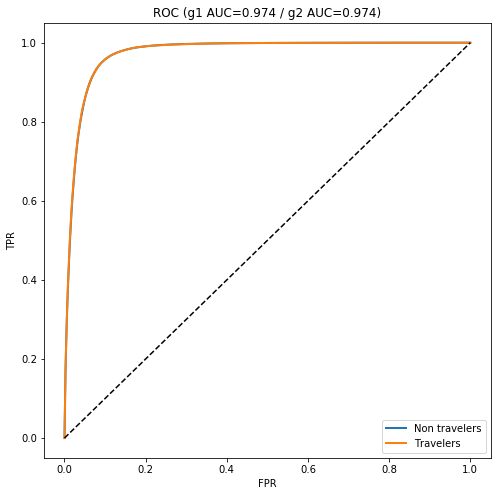

In [100]:
# plot ROC curve
fpr_group1, tpr_group1, thresholds = roc_curve(y_true_group1, y_pred_scaled_group1)
fpr_group2, tpr_group2, thresholds = roc_curve(y_true_group2, y_pred_scaled_group2)

fig,ax = plt.subplots(figsize=(8, 8))
ax.plot(fpr_group1, tpr_group1, lw=2, label='Non travelers')
ax.plot(fpr_group2, tpr_group2, lw=2, label='Travelers')
ax.plot([0, 1], [0, 1], 'k--')
ax.set_title(f'ROC (g1 AUC={auc_score_group1:.3f} / g2 AUC={auc_score_group2:.3f})')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.legend();